# Estimating the Loss of Medieval Literature with an Unseen Species model from Ecodiversity

In [1]:
import numpy as np
np.random.seed(76451)
import scipy.stats as stats
from scipy.special import gammaln
import scipy.optimize as optim
import pandas as pd
import matplotlib.pyplot as plt
import ptitprince as pt
from functools import partial
import seaborn as sb
from tqdm import tqdm_notebook

This notebook accompanies a short paper for the first [Computational Humanities Research Workshop](https://www.computational-humanities-research.org/) (18-20 november 2020; to be held online). It is part of a repository that contains all the code and software (with some documentation interwoven) necessary to replicate our findings; it will be archived on [Zenodo](https://zenodo.org/). The paper offers a more technical complement to and extension of a Dutch-language journal article that was previously published, but which was targeted at a broader audience of literary historians:

> Kestemont, M. & Karsdorp, F., ‘Het Atlantis van de Middelnederlandse ridderepiek. Een schatting van het tekstverlies met methodes uit de ecodiversiteit’, *Spiegel der Letteren* 61:3 (2019), 271-290.

We ran all the code below in an [Anaconda](https://www.anaconda.com/) installation of Python 3.6.10. The top-level directory of this repository has a `requirements.txt` file that you can use to install the more specific version of the third-party packages used here. Note that the data used here feature a number of minor improvements in comparison to that for the SDL paper.

## The loss of works

### Data

We start by loading the data for the case study, which is the tradition of Middle Dutch chivalric epics (*Middelnederlandse ridderepiek*, ca. 1150-1450 AD). This data comes in the form a single spreadsheet and has mainly been drawn Kienhorst's acclaimed 1988 repertory, with the addition of new manuscript finds since then:

In [2]:
df = pd.read_excel('../data/mnl_chiv.xlsx', header=None)
df.columns = ('work', 'sigle', 'signature', 'fragmentary')
df.head()

,work,sigle,signature,fragmentary
0,Aiol (1),H1,"Leiden, UB, BPL 1049; Brussel, KB, IV 816",True
1,Aiol (2),H2,"Breda, Arch. Begijnhof, z.s.",True
2,Alexanders geesten,"München, Bayerische Staatsbibliotheek, Cod. ge...","München, Bayerische Staatsbibliotheek, Cod. ge...",False
3,Alexanders geesten,H3,"Gent, UB, 2749,6",True
4,Alexanders geesten,H4,"Leiden, UB, Ltk. 1196",True


As you can see, each row represent a single textual witness or observation of a Middle Dutch chivalric epic:

- *work*: the title of the (abstract notion of a) "work" which is attested in the witness (i.e. the species in the ecological analogy);
- *sigle*: Kienhorst's code for the manuscript (not really used here, but useful for identification);
- *signature*: the signature of the fragment(s) of the textual witness that have been recovered. Often, there is just one signature but in some cases, more than one remnant of the same codex has emerged in different locations (separated by a semi-colon in the field). 
- *fragmentary*: we record the survival status of the work: did the witness survived in full (i.e. an entire codex) or just in one or more fragments (i.e. as so-called "maculature")? 

We transform this tabular data into the sort of "abundance data", needed for our analysis, capturing how often each type of species has been sighted:

In [4]:
types = df.groupby('work').size().sort_values(ascending=False).value_counts().sort_index()
types = types.to_frame(name='Works')
types['Witnesses'] = types.index
types.loc['Total']  = (types['Works'].sum(), np.sum(types['Works'] * types['Witnesses']))
types

,Works,Witnesses
1,45,1
2,13,2
3,6,3
4,2,4
5,4,5
6,1,6
7,1,7
10,2,10
17,1,17
Total,75,167


We convert that data into Latex for the paper:

In [5]:
print(types.to_latex(index=False, bold_rows=True))

\begin{tabular}{rr}
\toprule
 Works &  Witnesses \\
\midrule
    45 &          1 \\
    13 &          2 \\
     6 &          3 \\
     2 &          4 \\
     4 &          5 \\
     1 &          6 \\
     1 &          7 \\
     2 &         10 \\
     1 &         17 \\
    75 &        167 \\
\bottomrule
\end{tabular}



Then, we create a simple array holding these species counts or the attestation freqsuency of each of our 75 works:

In [6]:
cnts = df.groupby('work').size().values # ignore zero
cnts

array([ 1,  1,  1,  5,  2,  1,  2,  1,  1,  3,  1,  1,  2,  1,  1,  2,  1,
        1,  1,  2,  1,  1,  1,  1,  1, 17,  1,  4,  1,  7,  1,  1,  1,  1,
        2, 10,  4,  1,  3,  1,  1,  1,  1,  1,  1,  1,  1,  6,  1,  2,  5,
        5,  3,  2,  3,  1,  1,  3, 10,  2,  5,  1,  2,  2,  1,  1,  2,  1,
        1,  2,  1,  1,  1,  1,  3])

### Estimators

We start by estimating the original diversity of the corpus, or the number of species that once existed for which no records are extant anymore (i.e. all texts for which all witnesses are completely lost or which are at least not recovered yet presently). For this we use three different estimators that are known as "unseen species models".

#### Chao1

Our method of theoretical preference is `Chao1`: this method is non-parametric (i.e. no built-in assumptions or difficult parametrizarions), conservative (i.e. it estimates a theoretical *lower* bound for the diversity) and optimally suited for our kind of data (because we expect most of the unseen species to only have a small abundance, i.e. most currently unknown medieval texts are likely to have existed in a small number of copies. The metric has been detailed in multiple publications, but we found this paper to be particularly insightful:

> A. Chao & L. Jost, "Estimating diversity and entropy profiles via discovery rates of new species". *Methods in Ecology and Evolution* 6 (2015), 873–882.

The base implementation is the following:

In [7]:
def chao_richness(x):
    x, n = x[x > 0], x.sum()
    t = x.shape[0]
    f1, f2 = (x == 1).sum(), (x == 2).sum()
    return t + (n - 1) / n * ((f1 ** 2 / 2 / f2) if f2 > 0 else (f1 * (f1 - 1) / 2))

For our corpus, this gives the following estimate at face value:

In [9]:
chao_richness(cnts)

152.41824044219254

Surprisingly, this suggests that roughly half of the medieval texts in this genre somehow got lost or forgotten -- which is much higher than what was previously assumed in the literature (for instance, in Frits van Oostrom's acclaimed *Stemmen op schrift*). To get a sense of the uncertainty at work here, we can apply a bootstrapped procedure, in which we iteratively sample from the data to obtain a confidence interval (CI):

In [10]:
def bt_prob(x):
    x, n = x[x > 0], x.sum()
    f1, f2 = (x == 1).sum(), (x == 2).sum()
    C = 1 - f1 / n * (((n - 1) * f1 / ((n - 1) * f1 + 2 * f2)) if f2 > 0 else
                      ((n - 1) * (f1 - 1) / ((n - 1) * (f1 - 1) + 2)) if f1 > 0 else
                      0)
    W = (1 - C) / np.sum(x / n * (1 - x / n) ** n)
    p = x / n * (1 - W * (1 - x / n) ** n)
    f0 = np.ceil(((n - 1) / n * f1 ** 2 / (2 * f2)) if f2 > 0 else
                 ((n - 1) / n * f1 * (f1 - 1) / 2))
    p0 = (1 - C) / f0
    p = np.hstack((p, np.array([p0 for i in np.arange(f0)])))
    return p


def bootstrap(x, fn=chao_richness, n_iter=1000, conf=.95):
    # define a multinomial probability distribution
    # for the bootstrap procedure to sample from:
    p, n = bt_prob(x), x.sum()
    data_bt = np.random.multinomial(n, p, n_iter)
    
    pro = np.array([fn(row) for row in data_bt])
    
    pro_mean = pro.mean(0)
    
    lci_pro = -np.quantile(pro, (1 - conf) / 2, axis=0) + pro_mean
    uci_pro = np.quantile(pro, 1 - (1 - conf) / 2, axis=0) - pro_mean

    sd_pro = np.std(pro, axis=0)

    pro = pro_mean - pro
    return (lci_pro, uci_pro, sd_pro, pro)

For 10,000 iterations, that yields the following .95 CI:

In [11]:
def chao_estimate(x, n_iter=10000, conf=0.95):
    pro = chao_richness(x)
    (lci_pro, uci_pro, sd_pro, bt_pro) = bootstrap(x, fn=chao_richness, n_iter=n_iter, conf=conf)
    lci_pro, uci_pro = pro - lci_pro, pro + uci_pro
    bt_pro = pro - bt_pro
    return (lci_pro, uci_pro, bt_pro, pro)

In [12]:
lci_pro, uci_pro, chao1_pro, pro = chao_estimate(cnts)
print(f'Chao1: {pro:.2f} CI({lci_pro:.2f} - {uci_pro:.2f})')

Chao1: 152.42 CI(110.46 - 225.73)


#### Jackknife

Next up is the Jackknife estimator, an older and established method in ecology. Although it lacks theoretical support, it often yields surprisingly strong empirical performance. A nice and very complete comparison is offered in, for instance:

> E. Marcon, "Practical Estimation of Diversity from Abundance Data" (2015). URL: https://hal-agroparistech.archives-ouvertes.fr/hal-01212435, working paper or preprint.

The Jackknife is a general bias correction method that estimates the bias in the data through under-sampling it (i.e. a kind of cross-validation). Below goes a Python implementation of the reference code found in XXXX. (Note that *k*, or the number of observations left out in each fold, is automatically determined by the procedure and we only specify a maximum *k* in the function call).

In [13]:
def dbinom(x, size, prob):
    d = stats.binom(size, prob).pmf(x)
    return 1 if np.isnan(d) else d


def jackknife(data, k=5, conf=0.95):
    k0, k = k, min(len(np.unique(data)) - 1, 10)
    n = np.bincount(data)[1:]
    n = np.array((np.arange(1, n.shape[0] + 1), n)).T
    total = n[:, 1].sum()
    gene = np.zeros((k + 1, 5))
    gene[0, 0] = total
    for i in range(1, k + 1):
        gene[i, 0] = total
        gene[i, 3] = total
        for j in range(1, i + 1):
            gene[i, 0] = (
                gene[i, 0] +
                (-1)**(j + 1) * 2**i * dbinom(j, i, 0.5) * n[j - 1, 1])
            gene[i, 3] = gene[i, 3] + (-1)**(j + 1) * 2**i * dbinom(
                j, i, 0.5) * n[j - 1, 1] * np.prod(np.arange(1, j + 1))
        gene[i, 1] = -gene[i, 0]
        for j in range(1, i + 1):
            gene[i, 1] = (gene[i, 1] + (
                (-1)**(j + 1) * 2**i * dbinom(j, i, 0.5) + 1)**2 * n[j - 1, 1])
        gene[i, 1] = np.sqrt(gene[i, 1] + n[i:, 1].sum())
    if k > 1:
        for i in range(2, k + 1):
            gene[i - 1, 2] = -(gene[i, 0] - gene[i - 1, 0])**2 / (total - 1)
            for j in range(1, i):
                gene[i - 1, 2] = gene[i - 1, 2] + (
                    (-1)**(j + 1) * 2**(i) * dbinom(j, i, 0.5) -
                    (-1)**(j + 1) * 2**(i - 1) * dbinom(j, i - 1, 0.5)
                )**2 * n[j - 1, 1] * total / (total - 1)
            gene[i - 1, 2] = np.sqrt(gene[i - 1, 2] + n[i - 1, 1] * total /
                                     (total - 1))
            gene[i - 1, 4] = (gene[i, 0] - gene[i - 1, 0]) / gene[i - 1, 2]
    coe = stats.norm().ppf(1 - (1 - 0.95) / 2)
    x = gene[1:k + 1, 4] < coe
    if x.sum() == 0:
        jackest = gene[k, 0]
        sej = gene[k, 1]
        order = 1
    else:
        indicator = np.arange(1, k + 1)
        jackest = gene[indicator[x][0], 0]
        sej = gene[indicator[x][0], 1]
        order = np.arange(1, k + 2)[indicator[x][0]] - 1
    if k0 <= order:
        jackest = gene[k0, 0]
        sej = gene[k0, 1]
        order = k0
    return jackest, sej, order, jackest - coe * sej, jackest + coe * sej

The CI is also returned by this function (the selected *k* turns out to be 3 for this data):

In [14]:
jk, sej, order, jk_lci, jk_uci = jackknife(cnts)
print(f'Jackknife (@order={order}): {jk:.2f} CI({jk_lci:.2f} - {jk_uci:.2f})')

Jackknife (@order=3): 177.00 CI(127.81 - 226.19)


#### Egghe & Proot

Finally, we turn to one of few previous studies in the Humanities in this domain:
    
> L. Egghe & G. Proot, "The estimation of the number of lost multi-copy documents: A new type of informetrics theory",  *Journal of Informetrics* 1 (2007) 257–268.

This article is an important forerunner in a which a similar method has been applied to estimate the loss rates of multi-copy documents in the domain of printed editions. Because the notion of a print run (see the $alpha$ parameter below) is meaningless in the domain of handwritten works, it isn't straightforward to transpose this method to our case study but we include it nevertheless:

In [15]:
def ep(counts, alpha=500):
    ft = np.bincount(counts)[1:]
    S = ft.sum()
    P1, P2 = (counts == 1).sum(), (counts == 2).sum()
    P0 = (1 / (1 + (2 / (alpha - 1)) * (P2 / P1))) ** alpha
    S_lost = S * (P0 / (1 - P0))
    S_lost = S + S_lost
    return S_lost if not np.isinf(S_lost) else np.nan

For our data, an estimate is yielded that is in the range of (slightly higher than `Chao1`):

In [16]:
ep_score = ep(cnts)

We can apply the same bootstrap procedure as for `Chao1` to get a CI:

In [17]:
def ep_estimate(x, n_iter=10000, conf=0.95):
    pro = ep(x)
    (lci_pro, uci_pro, sd_pro, bt_pro) = bootstrap(x, fn=ep, n_iter=n_iter, conf=conf)
    lci_pro, uci_pro = pro - lci_pro, pro + uci_pro
    bt_pro = pro - bt_pro
    return (lci_pro, uci_pro, bt_pro, pro)

That gives us a sense of the (again, considerable!) uncertainty:

In [19]:
lci_pro, uci_pro, ep_pro, pro = ep_estimate(cnts)
print(f'Egghe & Proot: {pro:.2f} CI({lci_pro:.2f} - {uci_pro:.2f})')

Egghe & Proot: 170.72 CI(117.03 - 268.93)


Finally, we visualize the combined result of applying these three estimators in a "rain plot", showing the distribution and boxplot for `Chao1` and the Egghe-Proot method; for the `Jackknife`, we can only show the CI and default score (as vertical grey, dashed or solid lines):

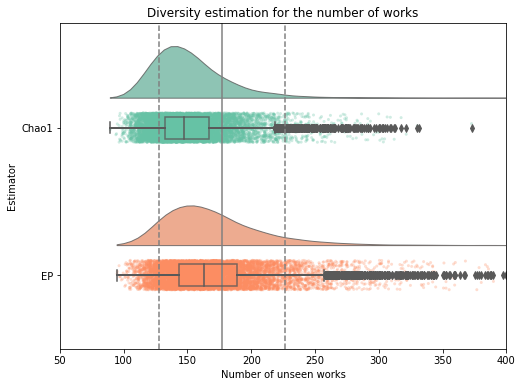

In [20]:
d = list([(x, 'Chao1') for x in chao1_pro])
d += list([(x, 'EP') for x in ep_pro])
bt = pd.DataFrame(d, columns=('bootstrap', 'Estimator'))
bt

fig, ax = plt.subplots(figsize=(8, 6))
pt.RainCloud(
    data=bt, x="Estimator", y="bootstrap", ax=ax, 
    orient="h", alpha=.8, bw=.2, rain_alpha=.3,
);

ax.axvline(jk, c='grey')
ax.axvline(jk_lci, c='grey', ls='--')
ax.axvline(jk_uci, c='grey', ls='--')
ax.set_xlabel('Number of unseen works')

ax.set_xlim([50, 400])
plt.title('Diversity estimation for the number of works');

### Maculature

An interesting extension of the kind of diversity estimation discussed above is to limit it to the fragmentary remains of witnesses only -- we owe this suggestion to prof. dr. Remco Sleiderink (University of Antwerp). Above, we freely mix physical documents that survived in their entirety (i.e. full codices) with fragmentary remains (sometimes, in the case of deliberately torn up "maculature", only a small shred of a book survives). It is unclear to us at this stage whether that is theoretically acceptable since both document types are characterized by very different survival routes. For that reason, we also include an estimate based on the fragmentary remains only.

Our data indicate whether a witness has survived fragmentarily (as "maculature") or not. In the former case, remnants of the very same source have sometimes emerged in different locales (in that case, multiple signatures are included). These also can be treated as different "sightings", but this time of a manuscript (instead of a work), which allows us to estimate (a lower bound for) the total number of manuscripts that were once cut up to be recycled.

Note that here, we are no longer estimating the loss of "works", but rather the loss of "documents". However, we are not estimating the size of the *full* corpus of documents that once existed (that will happen below), but *only* the size of the specific subgroup of manuscripts that once existed which were processed or recycled into maculature. To the best of our knowledge, very little is known on the ratio of "all manuscripts" vs "the number of manuscripts that were eventually recycled" in any mledieval literature, so this is very exciting.

First, we restrict the data to witnesses that survived fragmentarily:

In [21]:
mss_cnts = []
for sign, fragm in zip(df['signature'], df['fragmentary']):
    if fragm: # we ignore witnesses that survived in full
        try:
            mss_cnts.append(len(sign.split(';')))
        except AttributeError:
            pass
mss_cnts = np.array(mss_cnts)

This gives us a (much) smaller subset of the data, as shown in this bar plot:

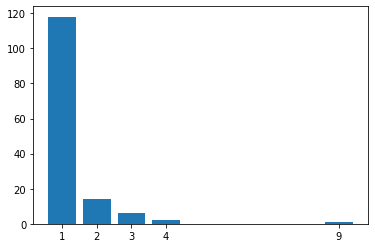

In [22]:
labels, counts = np.unique(mss_cnts, return_counts=True)
plt.bar(labels, counts, align='center')
plt.gca().set_xticks(labels);

The following statistics can be reported:

In [24]:
x = mss_cnts
x, n = x[x > 0], x.sum()
t = x.shape[0]
f1, f2 = (x == 1).sum(), (x == 2).sum()
print('number of fragments:', n)
print('number of documents:', t)
print('f1:', f1)
print('f2:', f2)

number of fragments: 181
number of documents: 141
f1: 118
f2: 14


Applying `Chao1` to this restricted data yields the following results:

In [25]:
mac_lci_pro, mac_uci_pro, mac_chao1_pro, mac_pro = chao_estimate(mss_cnts)
print(f'Chao1 (maculature): {mac_pro:.2f} CI({mac_lci_pro:.2f} - {mac_uci_pro:.2f})')

Chao1 (maculature): 635.54 CI(449.40 - 962.05)


To the best of our knowledge, this is the first published estimate of the number of manuscripts in this literature that were recycled into maculature. *If* these numbers are trustworthy -- and that's a big *if* -- they are surprisingly high: in combination with the analyses described below, it would seem that a surprisingly large share (up to one third!) of the manuscripts in this genre were eventually recycled. (And in a way, that's good news, because the discovery rates for fragmentary remains are nowadays much higher than for entire manuscripts.)

## The loss of documents

Above (and in our previous work), we limited ourselves to estimating the number of lost "works" in this data, but the number of lost "documents" is in fact equally relevant for medievalists -- especially for book historians. With the maculature paragraph above, we first ventured into that domain, but now we discuss a more principled approach to this problem.

It should ne noted that book historians have published earlier quantitative estimates as to the number of lost books in this domain.

### Minimum sampling

In [22]:
def minsample(x):
    n = x.sum()
    x = x[x > 0]
    t = x.shape[0]
    f1, f2 = (x == 1).sum(), (x == 2).sum()
    h = lambda x: 2 * f1 * (1 + x)
    v = lambda x: np.exp(x * (2 * f2 / f1))
    
    search_space = np.linspace(0, 100, 10000)
    hs = np.array(h(search_space))
    vs = np.array(v(search_space))
    diffs = np.abs(hs - vs)
    x_ast = search_space[diffs.argmin()]
    return n * x_ast

In [23]:
ms = minsample(cnts)
print('Estimate:', 100 / (minsample(cnts) / cnts.sum()), '% of documents survived')

Estimate: 8.1557911908646 % of documents survived


In [24]:
def minsample_estimate(x, n_iter=10000, conf=0.95):
    pro = minsample(x)
    (lci_pro, uci_pro, sd_pro, bt_pro) = bootstrap(x, fn=minsample, n_iter=n_iter, conf=conf)
    lci_pro, uci_pro = pro - lci_pro, pro + uci_pro
    bt_pro = pro - bt_pro
    return (lci_pro, uci_pro, bt_pro, pro)

In [25]:
lci, uci, bt_msample, ms = minsample_estimate(cnts)
print(f'Minimum sampling: {ms:.2f} CI({lci:.2f} - {uci:.2f})')

Minimum sampling: 2047.62 CI(1072.02 - 3844.50)


## Species Accumulation curve, with miminum sampling effort included

In [26]:
def bootstrap_re(x, fn=chao_richness, n_iter=1000, conf=.95):
    # define a multinomial probability distribution
    # for the bootstrap procedure to sample from:
    p, n = bt_prob(x), x.sum()
    data_bt = np.random.multinomial(n, p, n_iter)
    
    Dq = fn(x)
    
    pro = np.array([fn(row) for row in data_bt])
    
    error = stats.norm.ppf(1 - (1 - conf) / 2) * np.std(pro, 0)
    lci_pro = Dq - error
    uci_pro = Dq + error

    sd_pro = np.std(pro, axis=0)

    return (lci_pro, uci_pro, sd_pro, Dq, )


def rarefaction_extrapolation(x, max_steps):
    x, n = x[x > 0], x.sum()
    def _sub(m):
        if m <= n:
            return np.sum(1 - np.array(
                [np.exp(gammaln(n - i + 1) + gammaln(n - m + 1) - 
                        gammaln(n - i - m + 1) - gammaln(n + 1)) if i <= (n - m) else
                 0 for i in x]))
        else:
            S = (x > 0).sum()
            f1, f2 = (x == 1).sum(), (x == 2).sum()
            f0 = ((n - 1) / n * f1 * (f1 - 1) / 2) if f2 == 0 else ((n - 1) / n * f1**2 / 2 / f2)
            A = n * f0 / (n * f0 + f1)
            return S if f1 == 0 else (S + f0 * (1 - A**(m - n)))
    return np.array([_sub(mi) for mi in range(1, max_steps)])

In [27]:
num_docs = len(cnts) + int(minsample(cnts)) # n + m
lci_pro, uci_pro, sd_pro, Dq = bootstrap_re(cnts, fn=partial(rarefaction_extrapolation, max_steps=num_docs),
                                            n_iter=100)

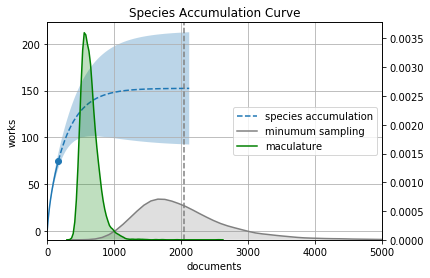

In [28]:
steps = np.arange(1, num_docs)
interpolated = np.arange(1, num_docs) < cnts.sum()
figure = plt.Figure(figsize=(8, 6))
plt.plot(steps[interpolated], Dq[interpolated], color='C0')
plt.plot(cnts.sum(), Dq[cnts.sum() - 1], 'o')
plt.plot(steps[~interpolated], Dq[~interpolated], '--', color='C0')
plt.fill_between(steps, lci_pro, uci_pro, alpha=0.3)
plt.grid()
plt.axvline(ms, ls='--', c='grey')
plt.xlabel('documents')
plt.ylabel('works')
plt.title('Species Accumulation Curve')
ax2 = plt.gca().twinx()
ax2.plot(np.nan, '--', color='C0', label='species accumulation')
sb.kdeplot(bt_msample, ax=ax2, color='grey', shade=True, label='minumum sampling')
sb.kdeplot(mac_chao1_pro, ax=ax2, color='green', shade=True, label='maculature')
ax2.legend(loc='center right')
plt.xlim([0, 5000]);

## Simulations

In the seminal paper on Malaysian butterflies, R.A. Fischer proposed the logseries model to capture the relative abundance of species in an assemblage. The logseries predicts the number of species at different levels of abundance ($n$ individuals) with the formula:

\begin{equation*}
S_n = \alpha x^n / n
\end{equation*}

In [29]:
def fisher_richness(idx, alpha, x_):
    return (alpha * (x_ ** idx)) / idx

Here, $S_n$ is the number of species with an abundance of $n$; $x$ = a positive constant ($0 < x < 1$) which is derived from the sample data set but generally approaches 1; $\alpha$ finally is the number of singleton species in the assemblage. We can fit this model to the Middle Dutch data (that seems to follow a surprisingly similar distribution):

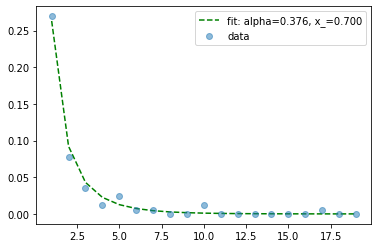

In [30]:
counts = df.groupby('work').size().sort_values(ascending=False).values
n_s = np.array(list(range(1, 20)))
abundance = np.array([np.sum(counts == i)/np.sum(counts) for i in n_s])

popt, pcov = optim.curve_fit(fisher_richness, xdata=n_s, ydata=abundance,
                             bounds=([0, 0.7], [100, 1.05]))
plt.plot(n_s, fisher_richness(n_s, *popt), 'g--',
         label='fit: alpha=%5.3f, x_=%5.3f' % tuple(popt))
plt.plot(n_s, abundance, 'o', label='data', alpha=0.5);
plt.legend();

Fisher's logseries can be used to define a discrete probability distribution, parametrized by two values:
 - the number of singleton species in the population
 - the maximum number of attestations for a single species (to put a practical cap on the distribution)

If we sample $num\_species$ species from this probability distribution, we can simulate virtual assemblages that mimic the properties of the observed data.

In [31]:
def fisher_pop(n, alpha=0.9, x=5, num_species=600):
    """
    alpha = number of singleton species (f1)
    n = max attestation frequency of a particular species
    x = constant [0, 1], approx. 1
    """
    orders = np.array([fisher_richness(i, alpha, x) for i in range(1, n + 1)])
    props = orders / orders.sum()
    assemblage = []
    elements = [i + 1 for i in np.arange(n)]
    for idx, sample in enumerate(np.random.choice(elements, num_species + 1, p=props)):
        assemblage.extend(sample * [idx])
    return np.array(assemblage)

assemblage = fisher_pop(n=50, alpha=75, x=.99, num_species=250)
assemblage

array([  0,   0,   1, ..., 250, 250, 250])

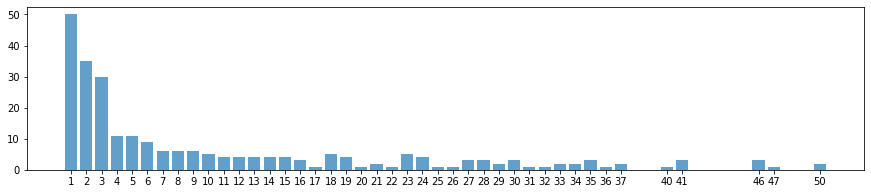

In [32]:
plt.figure(figsize=(15, 3))
abundance_cnt = np.bincount(assemblage)[1:]
labels, counts = np.unique(abundance_cnt, return_counts=True)
plt.bar(labels, counts, align='center', alpha=0.7)
plt.gca().set_xticks(labels);

The original species in the simulated assemblage:

In [33]:
print('# works:',  len(abundance_cnt))
print('# documents:', abundance_cnt.sum())
print('# singletons:', abundance_cnt[abundance_cnt == 1].sum(),
      f'({abundance_cnt[abundance_cnt == 1].sum()/len(abundance_cnt) * 100 :.2f}%)')

# works: 250
# documents: 2567
# singletons: 50 (20.00%)


Next, we can stochastically sample (at certain "keep rates") from this population to simulate the historic loss of documents.

In [34]:
def loss(assemblage_, keep_rate):
    assemblage_ = list(assemblage_)
    np.random.shuffle(assemblage_)
    retrieved = assemblage_[:int(len(assemblage_) * keep_rate)]
    return np.array(retrieved)

retrieved = loss(assemblage, keep_rate=0.20)

Let us check what this sampling did to our statistics:

In [35]:
_, impaired_counts = np.unique(retrieved, return_counts=True)
print('Impaired population:')
print('# works:',  len(impaired_counts))
print('# documents:', impaired_counts.sum())
print('# singletons:', impaired_counts[impaired_counts == 1].sum(),
      f'({impaired_counts[impaired_counts == 1].sum()/len(impaired_counts) * 100:.2f}%)')

Impaired population:
# works: 150
# documents: 513
# singletons: 61 (40.67%)


This makes sense (as is also illustrated in the plot below): the number of documents goes down by a factor of the keep rate and inevitably we lose some works, but not at the same rate (we primarily lose those that existed in low abundance in the original population). Perhaps counterintuitively, this also implies that the number of singletons should proportionally go up in the impaired sample.

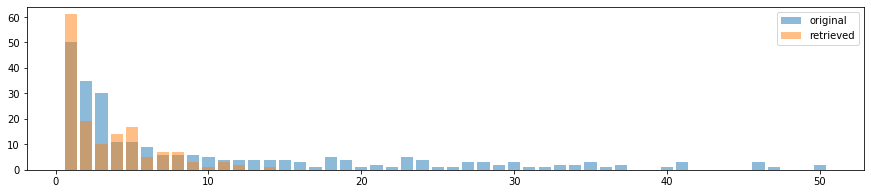

In [36]:
plt.figure(figsize=(15, 3))
abundance_cnt = np.bincount(assemblage)[1:]
labels, counts = np.unique(abundance_cnt, return_counts=True)
plt.bar(labels, counts, align='center', alpha=0.5, label='original')

impaired_labels_, impaired_counts_ = np.unique(impaired_counts, return_counts=True)
plt.bar(impaired_labels_, impaired_counts_, align='center', alpha=0.5, label='retrieved')
plt.legend();

In [37]:
print(chao_richness(impaired_counts))
print(jackknife(impaired_counts)[0])
print(ep(impaired_counts))

247.73017338668308
286.0
323.20537893044275


### Loss of works

In [38]:
def rmse(pred, true):
    return np.sqrt((pred - true) ** 2)

def e(pred, true):
    return pred - true

num_documents = np.arange(500, 2500, 100)
keep_rates = np.linspace(0.05, 0.95, len(num_documents))
n_experiments = 10

num_works = 250
f1 = 75
x = .99

In [39]:
results, doc_results = [], []
for i, num_doc in enumerate(tqdm_notebook(num_documents)):
    for kr in keep_rates: 
        for j in range(n_experiments):
            assemblage = fisher_pop(n=num_doc, alpha=f1, x=x, num_species=num_works)
            retrieved = loss(assemblage, keep_rate=kr)
            _, impaired_counts = np.unique(retrieved, return_counts=True)
            results.append({'keep rate': kr, 'estimator': 'Egghe & Proot',
                            'diversity': ep(impaired_counts, alpha=50),
                            'num_documents': num_doc})
            results.append({'keep rate': kr, 'estimator': 'Jackknife',
                            'diversity': jackknife(impaired_counts)[0],
                            'num_documents': num_doc})
            results.append({'keep rate': kr, 'estimator': 'Chao1',
                            'diversity': chao_richness(impaired_counts),
                            'num_documents': i})
            doc_results.append({'keep rate': kr, 'diversity': minsample(impaired_counts),
                               'num_documents': num_doc})

S_df = pd.DataFrame(results)
D_df = pd.DataFrame(doc_results)

100%|██████████| 20/20 [10:05<00:00, 30.29s/it]


In [40]:
S_df['Error'] = S_df['diversity'] - num_works
S_df['AbsError'] = np.abs(S_df['Error'])

In [41]:
S_df.head(10)

,keep rate,estimator,diversity,num_documents,Error,AbsError
0,0.05,Egghe & Proot,139.974451,500,-110.025549,110.025549
1,0.05,Jackknife,152.000000,500,-98.000000,98.000000
2,0.05,Chao1,130.800000,0,-119.200000,119.200000
3,0.05,Egghe & Proot,145.352745,500,-104.647255,104.647255
4,0.05,Jackknife,154.000000,500,-96.000000,96.000000
5,0.05,Chao1,132.954665,0,-117.045335,117.045335
6,0.05,Egghe & Proot,126.373467,500,-123.626533,123.626533
7,0.05,Jackknife,134.000000,500,-116.000000,116.000000
8,0.05,Chao1,123.049793,0,-126.950207,126.950207
9,0.05,Egghe & Proot,156.859811,500,-93.140189,93.140189


In [42]:
D_df['Error'] = D_df['diversity'] - D_df['num_documents']
D_df['AbsError'] = np.abs(D_df['Error'])
D_df.head(10)

,keep rate,diversity,num_documents,Error,AbsError
0,0.05,1352.535254,500,852.535254,852.535254
1,0.05,1634.293429,500,1134.293429,1134.293429
2,0.05,1050.865087,500,550.865087,550.865087
3,0.05,1638.883888,500,1138.883888,1138.883888
4,0.05,1603.960396,500,1103.960396,1103.960396
5,0.05,2916.291629,500,2416.291629,2416.291629
6,0.05,2020.952095,500,1520.952095,1520.952095
7,0.05,1996.599660,500,1496.599660,1496.599660
8,0.05,2757.535754,500,2257.535754,2257.535754
9,0.05,2286.948695,500,1786.948695,1786.948695


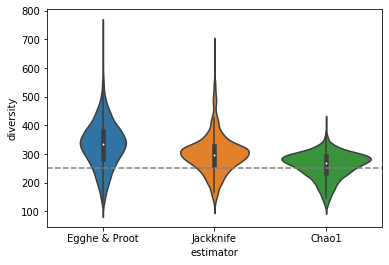

In [43]:
ax = sb.violinplot(x="estimator", y="diversity", data=S_df)
ax.axhline(num_works, ls='--', c='grey')

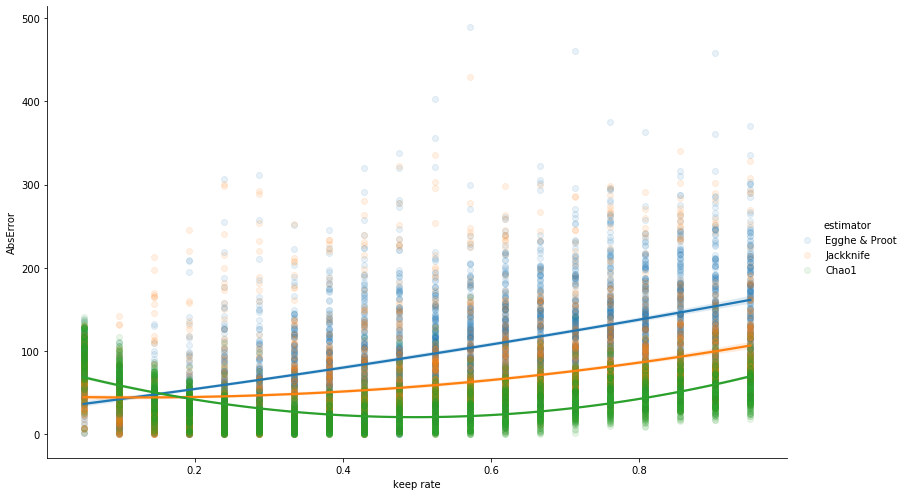

In [44]:
g = sb.lmplot(x="keep rate", y="AbsError", hue="estimator", order=2,
              ci=95, data=S_df, scatter_kws={'alpha':0.1}, height=7, aspect=1.6)